<a href="https://colab.research.google.com/github/nates27/multi-task-learning/blob/main/bt5151_gp_npk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 100.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.9 MB/s eta 0:00:00


In [3]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=c49144c365375f63ff3fcaa86635a2494b7bbb0ba652d023392080f21020fb5e
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [4]:
pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 29.4 MB/s eta 0:00:00


In [5]:
!pip install ax-platform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.8/521.8 kB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.6 MB/s eta 0:00:00


# Imports and Classes #

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [7]:
import matplotlib.pyplot as plt
import re
from collections import OrderedDict
import torch
import transformers
from transformers import AlbertTokenizer, AlbertModel, DistilBertTokenizer, DistilBertModel, RobertaTokenizer, RobertaModel
from torch.utils.data import Dataset, DataLoader
from torch import cuda
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
device = 'cuda' if cuda.is_available() else 'cpu'
import wandb

### Training and Inference Loops ###

#I. Data Preprocessing #

### EDA ###

In [8]:
def data_quality(df):
  # find datatype of each column
  data_types = pd.DataFrame(df.dtypes, columns=['Data Type'])

  # count number of missing observations by column
  missing_data_counts = pd.DataFrame(df.isnull().sum(), columns=['Missing Values'])

  # count number of present observations by column
  present_data_counts = pd.DataFrame(df.count(), columns=['Present Values'])

  # count number of unique observations by column
  unique_value_counts = pd.DataFrame(columns=['Unique Values'])
  for v in list(df.columns.values):
      unique_value_counts.loc[v] = [df[v].nunique()]

  data_quality_report = pd.concat([present_data_counts, missing_data_counts, unique_value_counts], axis=1)
  return data_quality_report

In [9]:
d_train_orig = pd.read_csv("/content/drive/MyDrive/BT5151/group_project/train.csv")
d_test_orig = pd.read_csv("/content/drive/MyDrive/BT5151/group_project/test.csv")
s_train_orig = pd.read_csv("/content/drive/MyDrive/BT5151/group_project/tweets.csv")

In [10]:
d_train_orig.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
d_test_orig.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [12]:
s_train_orig.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [13]:
print(f"d_train:{d_train_orig.shape}\nd_test:{d_test_orig.shape}\ns_test:{s_train_orig.shape}")

d_train:(7613, 5)
d_test:(3263, 4)
s_test:(27481, 4)


In [14]:
total = d_train_orig.target.value_counts().sum()
neg = d_train_orig.target.value_counts()[0]
pos = d_train_orig.target.value_counts()[1]
print(f"Not Disaster: Count = {neg} Percent = {neg/total}\n"
     f"Disaster:  Count = {pos} Percent = {pos/total}\n")

Not Disaster: Count = 4342 Percent = 0.5703402075397347
Disaster:  Count = 3271 Percent = 0.4296597924602653



In [15]:
total = s_train_orig.sentiment.value_counts().sum()
neu = s_train_orig.sentiment.value_counts()['neutral']
neg = s_train_orig.sentiment.value_counts()['negative']
pos = s_train_orig.sentiment.value_counts()['positive']
print(f"Neutral: Count = {neu} Percent = {neu/total}\n"
    f"Negative: Count = {neg} Percent = {neg/total}\n"
     f"Positve:  Count = {pos} Percent = {pos/total}\n")

Neutral: Count = 11118 Percent = 0.4045704304792402
Negative: Count = 7781 Percent = 0.2831410792911466
Positve:  Count = 8582 Percent = 0.3122884902296132



In [16]:
d_train_orig.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [17]:
s_train_orig.columns

Index(['textID', 'text', 'selected_text', 'sentiment'], dtype='object')

In [18]:
print(data_quality(d_train_orig))

          Present Values  Missing Values  Unique Values
id                  7613               0           7613
keyword             7552              61            221
location            5080            2533           3341
text                7613               0           7503
target              7613               0              2


In [19]:
print(data_quality(s_train_orig))

               Present Values  Missing Values  Unique Values
textID                  27481               0          27481
text                    27480               1          27480
selected_text           27480               1          22463
sentiment               27481               0              3


### Data Preprocessing ###

In [20]:
# Helper function that will map sentiment to numerical values
def map_sentiment(x):
    if x == "negative":
        return 1
    elif x =="neutral":
        return 0
    elif x =="positive":
        return 2
    else:
        return None

# Custom Dataset for D1 that will tokenize text and arrange output and labels in a dictionary
class DisasterData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.target
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding = 'max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

# Custom Dataset for D2 that will tokenize text and arrange output and labels in a dictionary
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.target
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding = 'max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }
 

In [21]:
# Helper function to remove URLs. May or may not be used
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

In [22]:
# Creating copies of the dataset
d_train = d_train_orig.copy()
d_test = d_test_orig.copy()
s_train = s_train_orig.copy()

In [23]:
# Remove null values
s_train.drop(s_train[s_train["textID"]=="fdb77c3752"].index, inplace=True)

In [24]:
# Ignore removing URLs for now as tokenizer can probably handle URLs
# d_train['text'] = d_train.apply(lambda x: cleaning_URLs(x['text']),axis=1)
# #d_test['text'] = d_test.apply(lambda x: cleaning_URLs(x['text']),axis=1)
# s_train['text'] = s_train.apply(lambda x: cleaning_URLs(x['text']),axis=1)

In [25]:
# Removing duplicate text, skipped for now as dropping them will have an impact in later tasks
# d_train.drop_duplicates(subset=['text'], inplace=True)
# d_train.shape

In [26]:
# Removing duplicate text
# s_train.drop_duplicates(subset=['text'], inplace=True)
# s_train.shape

In [27]:
# Adding task id to the datasets, might be needed later on
d_train['id'] = 1
s_train['id'] = 2
d_train.reset_index(inplace=True)
s_train.reset_index(inplace=True)
s_train_text = s_train[['text','id','index']].copy()
d_train_text = d_train[['text','id','index']].copy()

In [28]:
# Mapping sentiment labels to numbers
s_train['sentiment'] = s_train.apply(lambda x: map_sentiment(x.sentiment), axis=1)
s_train.rename(columns={'sentiment':'target'}, inplace=True)
# Creating copies of the data for passing in to custom dataset
d_train_select =  d_train[['text','target']].copy()
s_train_select = s_train[['text','target']].copy()

In [29]:
# Creating the corpus of text as instructed, but won't be used
corpus = pd.concat([d_train_select[["text"]], s_train_select[['text']]])

In [30]:
corpus.shape

(35093, 1)

In [31]:
# Pre-trained tokenizer to be used
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)

# # Hyperparameters below for actual model used
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 32

# Hyperparameters below for experimenting on freezing the pre-trained MLM models
# MAX_LEN = 512
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32

In [32]:
# Create train-validate spilts
d_train_data, d_val_data = train_test_split(d_train_select, test_size=0.2, stratify=d_train_select['target'],
                                 random_state=2023)

s_train_data, s_val_data= train_test_split(s_train_select, test_size=0.2, stratify=s_train_select['target'],
                                 random_state=2023)

# Dropping the index because it can mess up the loops
d_train_data.reset_index(inplace=True,drop =True)
d_val_data.reset_index(inplace=True, drop =True)
s_train_data.reset_index(inplace=True, drop =True)
s_val_data.reset_index(inplace=True,  drop =True)

In [33]:
d_train_data.shape

(6090, 2)

In [34]:
s_train_data.head()

,text,target
0,June gloom seems to have arrived early,0
1,Sad that our neighbors just cut down ALL the t...,1
2,OHH yeah i sometimes forget your in the oth...,0
3,Join the biggest and bestest group on facebook...,2
4,i lost one of my best friends iï¿½m sooo sad,1


In [35]:
# Create D1 and D2 training and validation Datasets. This will tokenize the datasets on the fly
d1_train_set= DisasterData(d_train_data, tokenizer, MAX_LEN)
d1_val_set = DisasterData(d_val_data, tokenizer, MAX_LEN)

d2_train_set= SentimentData(s_train_data, tokenizer, MAX_LEN)
d2_val_set = SentimentData(s_val_data, tokenizer, MAX_LEN)

In [36]:
# Create D1 and D2 dataloaders
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

d1_train_loader = DataLoader(d1_train_set, **train_params)
d1_val_loader = DataLoader(d1_val_set, **test_params)

d2_train_loader = DataLoader(d2_train_set, **train_params)
d2_val_loader = DataLoader(d2_val_set, **test_params)

# II. Model Training #

In [37]:
# Final architecture to be used for Task 1 and Task 2
class NetMultiTask(torch.nn.Module):
    def __init__(self):
        super(NetMultiTask, self).__init__()
        self.net = RobertaModel.from_pretrained("roberta-base")
        
        self.pre_classifier1 = torch.nn.Linear(768, 768)
        self.dropout1 = torch.nn.Dropout(0.2)
        self.classifier1 = torch.nn.Linear(768, 2)
        
        self.pre_classifier2 = torch.nn.Linear(768, 768)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.classifier2 = torch.nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.net(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
      
        pooler1 = self.pre_classifier1(pooler)
        pooler1 = torch.nn.ReLU()(pooler1)
        pooler1 = self.dropout1(pooler1)
        output1 = self.classifier1(pooler1)

        pooler2 = self.pre_classifier2(pooler)
        pooler2 = torch.nn.ReLU()(pooler2)
        pooler2 = self.dropout2(pooler2)
        output2 = self.classifier2(pooler2)
        
        return output1, output2

Liu, Y., Ott, M., Goyal, N., Du, J., Joshi, M., Chen, D., Levy, O., Lewis, M., Zettlemoyer, L., & Stoyanov, V. (2019). RoBERTa: A robustly optimized BERT pretraining approach. CoRR, abs/1907.11692.

**Question**: Assume the model is deployed in a server within your news agency. Explain the inputs to the model and predictions that it is expected to output. Also explain how the predictions will be used by reporters.

**Answer**:<br>
<p>We are using the RoBERTa architecture in thie model above where we use its embeddings on two classifiers in the same neural network. The raw inputs to the model can be any text, but in this project's context it will be tweets on which the model will be trained on. The text must first be passed to RoBERTa's pre-trained tokenizer which will convert the text to the tensors and attention masks needed for the RoBERTa model. The tensors and attentioin masks will then pass through RoBERTa's architecture and we will use its last hidden state as word embeddings. The word embeddings will then be passed to two separate dense layers with different heads. The first will head has two outputs and the second head as three outputs.</p>
<p>The first head can be used by reporters to classify a tweet if it's pertaining to a disaster or not. These can be used by reporters for example as an early warning system where the system can get tweets through the Twitter API, pass it through the model, predict the tweets, and then notifiy reporters if there are large amounts of disaster tweets happening in real time. This will enable them to respond and report on disasters quickly.</p>
<p>The second head can be used by reporters and the news agency to gauge sentiment on their news/opinion articles released on twitter and then track its engagement. This can be done by setting up a sentiment analysis system using this model. The system can work by pulling replies or retweets from the reporters' tweets using the Twitter API, passing them through the model to get sentiment predictions, and then analyzing sentiment classes of the reporters' tweets.

# III. Neural Network Multi Task Learing #

### Task 3.1 and Task 3.2 ###
1. Train the model M only for T1 on Dtrain. Call the trained val 1
model MD . Evaluate MD on D and report its 111
performance metric (F1 score) for the first task, PerfT (MD |Dval). Also print the confusion matrix. ###

2. Train the model M only for T2 on Dtrain . Call the trained
model M . Evaluate the trained M2 on Dval and report D2 D2 2 val
its performance metric (Accuracy) PerfT (MD |D Also print the confusion matrix.

#### Helper functions for the training and validation loops ####

In [38]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [39]:
def train(model, epoch, training_loader, mode):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()

    
    for _,data in enumerate(tqdm(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        output1, output2 = model(ids, mask, token_type_ids)

        if mode == 1:
            output = output1
        elif mode == 2:
            output = output2
        else:
            assert False, 'Bad Task ID passed'


        loss = loss_function(output, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(output.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")
    return

def valid(model, testing_loader, mode):
    model.eval()
    #n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    tr_loss=0
    predicts = []

    with torch.no_grad():
        for _, data in enumerate(tqdm(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)

            output1, output2 = model(ids, mask, token_type_ids)

            if mode == 1:
                output = output1
            elif mode == 2:
                output = output2
            else:
                assert False, 'Bad Task ID passed'

            loss = loss_function(output, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(output.data, dim=1)
            
            for i in range(targets.size(0)):
                predicts.append({
                    "predict": big_idx[i].item(),
                    "target": targets[i].item()
                })
    df = pd.DataFrame(predicts)
    return df

#### Training code used ####

Please refer to `learn_multitask.py` for working code

In [40]:
# Specifying the learning rate for both tasks
LEARNING_RATE = 1e-05

#### Perfomance Metrics and Confusion Matrices ####

In [41]:
# Loading the saved predictions for reporting metrics
predicts_d1 = pd.read_csv("/content/drive/MyDrive/BT5151/group_project/predicts_d1_roberta_final.csv", index_col=0)
predicts_d2 = pd.read_csv("/content/drive/MyDrive/BT5151/group_project/predicts_d2_roberta_final.csv", index_col=0)

In [42]:
print(classification_report(predicts_d1.target, predicts_d1.predict))
print(f"D1 F1: {f1_score(predicts_d1.target, predicts_d1.predict)}\n"
      f"D1 Accuracy: {accuracy_score(predicts_d1.target, predicts_d1.predict)}\n")

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       869
           1       0.81      0.81      0.81       654

    accuracy                           0.84      1523
   macro avg       0.83      0.83      0.83      1523
weighted avg       0.84      0.84      0.84      1523

D1 F1: 0.8091603053435114
D1 Accuracy: 0.8358502954694682



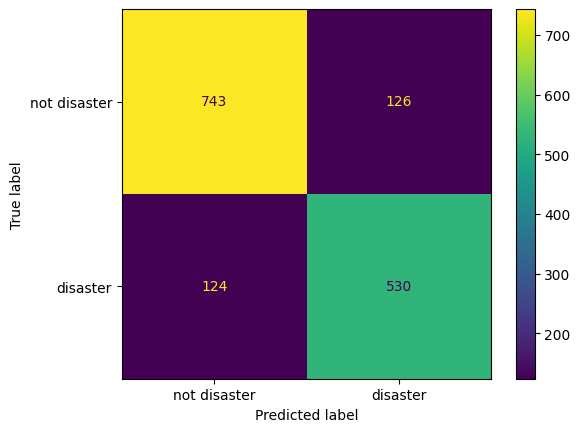

In [43]:
cm_d1 = confusion_matrix(predicts_d1.target, predicts_d1.predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_d1, display_labels=['not disaster', 'disaster'])
disp.plot()
plt.show()

In [44]:
print(classification_report(predicts_d2.target, predicts_d2.predict))
print(f"D2 F1: {f1_score(predicts_d2.target, predicts_d2.predict, average='weighted')}\n"
      f"D2 Accuracy: {accuracy_score(predicts_d2.target, predicts_d2.predict)}\n")

              precision    recall  f1-score   support

           0       0.75      0.73      0.74      2223
           1       0.77      0.80      0.78      1556
           2       0.83      0.83      0.83      1717

    accuracy                           0.78      5496
   macro avg       0.78      0.78      0.78      5496
weighted avg       0.78      0.78      0.78      5496

D2 F1: 0.7781284760442189
D2 Accuracy: 0.7783842794759825



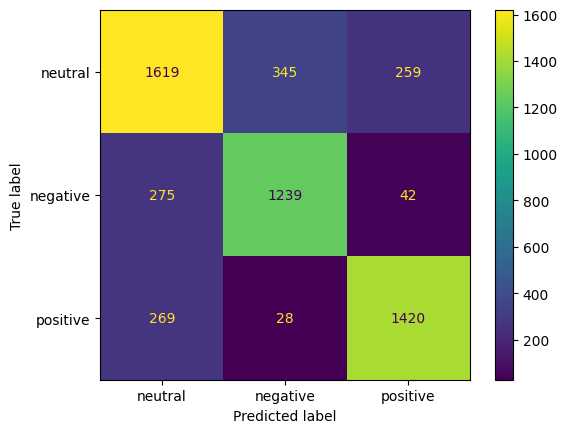

In [45]:
cm_d2 = confusion_matrix(predicts_d2.target, predicts_d2.predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_d2, display_labels=['neutral', 'negative','positive'])
disp.plot()
plt.show()

### Task 3.3 ###
Estimate the sentiment labels for the tweets in D1

In [46]:
# model_path = "/content/drive/MyDrive/BT5151/group_project/roberta_d2_final.bin" 
# model_d2 = torch.load(model_path, map_location=device)

In [47]:
# data_quality(d_val_data)

In [48]:
#d1_train_infer = SentimentData(d_train_data, tokenizer, MAX_LEN)
# d1_val_infer = SentimentData(d_val_data, tokenizer, MAX_LEN)

In [49]:
# test_params = {'batch_size': VALID_BATCH_SIZE,
#                 'shuffle': False,
#                 'num_workers': 0
#                 }
# d1_train_inferloader = DataLoader(d1_train_infer, **test_params)
# d1_val_inferloader = DataLoader(d1_val_infer, **test_params)

In [50]:
# loss_function = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params = model_d2.parameters(), lr = LEARNING_RATE)
# predicts_d1_train_infer = valid(model_d2, d1_train_inferloader, mode=2)
# predicts_d1_val_infer = valid(model_d2, d1_val_inferloader, mode=2)

In [51]:
# print(f"D1 Train Sentiment:\n{predicts_d1_train_infer['predict'].value_counts()}\n"
# f"D1 Val Sentiment:\n{predicts_d1_val_infer['predict'].value_counts()}")

In [52]:
# predicts_d1_train_infer.drop(columns='target', inplace=True)
# predicts_d1_val_infer.drop(columns='target', inplace=True)

In [53]:
# d1_train_augment = d_train_data.merge(predicts_d1_train_infer, left_index=True, right_index=True)
# d1_train_augment.rename({'predict': 'sentiment'}, axis =1, inplace=True)
# d1_val_augment = d_val_data.merge(predicts_d1_val_infer, left_index=True, right_index=True)
# d1_val_augment.rename({'predict': 'sentiment'}, axis =1, inplace=True)

In [54]:
# print(f"D1 Train Augmented: {d1_train_augment.shape}\nD1 Val Augmented: {d1_val_augment.shape}")

In [55]:
# d1_train_augment.head()

In [56]:
# d1_val_augment.head()

In [57]:
# d1_augment = pd.concat([d1_train_augment, d1_val_augment], ignore_index= True)

In [58]:
# d1_augment.head()

In [59]:
# d1_augment['sentiment'].value_counts()

In [60]:
# data_quality(d1_augment)

In [61]:
# # Saving d1_augment for future use
# d1_train_augment.to_csv("/content/drive/MyDrive/BT5151/group_project/d1_train_augment.csv")
# d1_val_augment.to_csv("/content/drive/MyDrive/BT5151/group_project/d1_val_augment.csv")
# d1_augment.to_csv("/content/drive/MyDrive/BT5151/group_project/d1_augment.csv")

Analysis: 

### Task 3.4 ###

In [62]:
# Setting the sentiment "target" column back to "sentiment"
s_train_concat = s_train_data.rename(columns={"target":"sentiment"}).copy()
s_val_concat = s_val_data.rename(columns={"target":"sentiment"}).copy()

In [63]:
s_train_concat.head()

,text,sentiment
0,June gloom seems to have arrived early,0
1,Sad that our neighbors just cut down ALL the t...,1
2,OHH yeah i sometimes forget your in the oth...,0
3,Join the biggest and bestest group on facebook...,2
4,i lost one of my best friends iï¿½m sooo sad,1


In [64]:
# Concatenating the datasets to creat D_12
sd_train_data = pd.concat([d_train_data, s_train_concat], ignore_index=True)
sd_val_data = pd.concat([d_val_data, s_val_concat], ignore_index=True)

In [65]:
sd_train_data.head()

,text,target,sentiment
0,Ancient Mayan Tablet found via http://t.co/LmU...,0.0,NaN
1,Incredulous at continued outcry of welfare bei...,1.0,NaN
2,Hi yall this poem is called is the one about t...,0.0,NaN
3,The Police Chief assured the crowd that this o...,1.0,NaN
4,Learning from the Legacy of a Catastrophic Eru...,1.0,NaN


In [66]:
# Checking quality
data_quality(sd_train_data)

,Present Values,Missing Values,Unique Values
text,28074,0,27996
target,6090,21984,2
sentiment,21984,6090,3


In [67]:
sd_train_data.shape

(28074, 3)

In [68]:
sd_train_data.columns

Index(['text', 'target', 'sentiment'], dtype='object')

In [69]:
# Custom Dataset class for D_12
class DataCombined(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.target = self.data.target
        self.sentiment = self.data.sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding = 'max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'labels': (self.target[index], self.sentiment[index]) #output labels in a tuple for indexing later during training loop
        }

### Task 3.5 ###
 Model Training pipeline

In [70]:
# Hyperparameters for training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
LEARNING_RATE = 1e-05

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

# Creating the datasets
sd_train_dataset = DataCombined(sd_train_data, tokenizer=tokenizer, max_len=MAX_LEN)
sd_val_dataset = DataCombined(sd_val_data, tokenizer=tokenizer, max_len=MAX_LEN)
# Loading the datasets in the dataloaders
sd_train_loader = DataLoader(sd_train_dataset, **train_params)
sd_val_loader = DataLoader(sd_val_dataset, **test_params)

**Preserving the AHA moment XD**

In [71]:
#sd_sample = next(iter(sd_train_loader))

In [72]:
#sd_sample['ids'][sd_sample['labels'][1]==0]

In [73]:
#sd_sample['ids'].size()
#sd_sample['ids'][~np.isnan(sd_sample['labels'][0].numpy()) == True]

In [74]:
#sd_sample["labels"][0][~np.isnan(sd_sample['labels'][0].numpy()) == True].long()

In [75]:
#sd_sample["labels"][1][~np.isnan(sd_sample['labels'][1].numpy()) == True].long()

In [76]:
# idx1 = ~np.isnan(sd_sample['labels'][0].numpy())
# idx2 = ~np.isnan(sd_sample['labels'][1].numpy())

In [77]:
# idx1

In [78]:
# idx2

In [79]:
# Now we know what to do, let's do the functions!

def null_tensor(tensor):
    if torch.isnan(tensor) == True:
        return torch.tensor(0)
    else:
        return tensor

def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

def train_hydra(model, epoch, training_loader, testing_loader, lambda1, lambda2):
    d1_tr_loss = 0
    d1_n_correct = 0
    d1_nb_tr_steps = 0
    d1_nb_tr_examples = 0
    d2_tr_loss = 0
    d2_n_correct = 0
    d2_nb_tr_steps = 0
    d2_nb_tr_examples = 0
    total_tr_loss = 0
    
    d1_val_loss = 0
    d1_val_n_correct = 0
    d1_nb_val_steps = 0
    d1_nb_val_examples = 0
    
    d2_val_loss = 0
    d2_val_n_correct = 0
    d2_nb_val_steps = 0
    d2_nb_val_examples = 0
    total_val_loss = 0

    model.train()
    for loop, data in enumerate(tqdm(training_loader, 0)):
        d1_ids = data['ids'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
        d1_mask = data['mask'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
        d1_token_type_ids = data['token_type_ids'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
        d1_targets = data['labels'][0][~np.isnan(data['labels'][0].numpy()) == True].long().to(device, dtype = torch.long)

        d2_ids = data['ids'][~np.isnan(data['labels'][1].numpy()) == True].to(device, dtype = torch.long)
        d2_mask = data['mask'][~np.isnan(data['labels'][1].numpy()) == True].to(device, dtype = torch.long)
        d2_token_type_ids = data['token_type_ids'][~np.isnan(data['labels'][1].numpy()) == True].to(device, dtype = torch.long)
        d2_sentiment = data['labels'][1][~np.isnan(data['labels'][1].numpy()) == True].long().to(device, dtype = torch.long)


        output1, _ = model(d1_ids, d1_mask, d1_token_type_ids)
        _, output2 = model(d2_ids, d2_mask, d2_token_type_ids)

        loss1 = loss_function(output1, d1_targets)
        loss1 = null_tensor(loss1)
        d1_tr_loss += check_null(lambda1*loss1.item())

        loss2 = loss_function(output2, d2_sentiment)
        loss2 = null_tensor(loss2)
        d2_tr_loss += check_null(lambda2*loss2.item())

        total_loss = (lambda1*loss1) + (lambda2*loss2)
        total_tr_loss += total_loss.item()
        

        big_val_d1, big_idx_d1 = torch.max(output1.data, dim=1)
        d1_n_correct += calcuate_accuracy(big_idx_d1, d1_targets)

        big_val_d2, big_idx_d2 = torch.max(output2.data, dim=1)
        d2_n_correct += calcuate_accuracy(big_idx_d2, d2_sentiment)

        d1_nb_tr_steps += 1
        d1_nb_tr_examples += d1_targets.size(0)

        d2_nb_tr_steps += 1
        d2_nb_tr_examples += d2_sentiment.size(0)
        

        d1_loss_step = d1_tr_loss/d1_nb_tr_steps
        d1_accu_step = (d1_n_correct*100)/d1_nb_tr_examples


        d2_loss_step = d2_tr_loss/d2_nb_tr_steps
        d2_accu_step = (d2_n_correct*100)/d2_nb_tr_examples

        tr_loss_step = d1_loss_step + d2_loss_step
        
        optimizer.zero_grad()
        total_loss.backward()
        # # When using GPU
        optimizer.step()

        train_metrics = {"d1_train_loss": d1_loss_step,
            "d1_train_accuracy": d1_accu_step,
            "d2_train_loss": d2_loss_step,
            "d2_train_accuracy": d2_accu_step,
            "total_train_loss": tr_loss_step}
        
        wandb.log({**train_metrics})

    model.eval()
    with torch.no_grad():
        for _, data in enumerate(tqdm(testing_loader, 0)):
            d1_ids_val = data['ids'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
            d1_mask_val = data['mask'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
            d1_token_type_ids_val = data['token_type_ids'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
            d1_targets_val = data['labels'][0][~np.isnan(data['labels'][0].numpy()) == True].long().to(device, dtype = torch.long)

            d2_ids_val = data['ids'][~np.isnan(data['labels'][1].numpy()) == True].to(device, dtype = torch.long)
            d2_mask_val = data['mask'][~np.isnan(data['labels'][1].numpy()) == True].to(device, dtype = torch.long)
            d2_token_type_ids_val = data['token_type_ids'][~np.isnan(data['labels'][1].numpy()) == True].to(device, dtype = torch.long)
            d2_sentiment_val = data['labels'][1][~np.isnan(data['labels'][1].numpy()) == True].long().to(device, dtype = torch.long)

            output1_val, _ = model(d1_ids_val, d1_mask_val, d1_token_type_ids_val)
            _, output2_val = model(d2_ids_val, d2_mask_val, d2_token_type_ids_val)

            loss1_val = loss_function(output1_val, d1_targets_val)
            loss1_val = null_tensor(loss1_val)
            d1_val_loss += check_null(lambda1*loss1_val.item())

            loss2_val = loss_function(output2_val, d2_sentiment_val)
            loss2_val = null_tensor(loss2_val)
            d2_val_loss += check_null(lambda2*loss2_val.item())
            
            total_loss_val = (lambda1*loss1_val) + (lambda2*loss2_val)
            total_val_loss += total_loss_val.item()
            
            big_val_d1, big_idx_d1_val = torch.max(output1_val.data, dim=1)
            d1_val_n_correct += calcuate_accuracy(big_idx_d1_val, d1_targets_val)

            big_val_d2, big_idx_d2_val = torch.max(output2_val.data, dim=1)
            d2_val_n_correct += calcuate_accuracy(big_idx_d2_val, d2_sentiment_val)

            d1_nb_val_steps += 1
            d1_nb_val_examples += d1_targets_val.size(0)

            d2_nb_val_steps += 1
            d2_nb_val_examples += d2_sentiment_val.size(0)
            
            try:
                d1_loss_step_val = d1_val_loss/d1_nb_val_steps
            except ZeroDivisionError:
                d1_loss_step_val = 0
            try:
                d1_accu_step_val = (d1_val_n_correct*100)/d1_nb_val_examples
            except ZeroDivisionError:
                d1_accu_step_val = 0


            try:
                d2_loss_step_val = d2_val_loss/d2_nb_val_steps
            except ZeroDivisionError:
                d2_loss_step_val = 0
            
            try:
                d2_accu_step_val = (d2_val_n_correct*100)/d2_nb_val_examples
            except ZeroDivisionError:
                d2_accu_step_val = 0

            tr_loss_step_val = d1_loss_step_val + d2_loss_step_val

            test_metrics = {"d1_test_loss": d1_loss_step_val,
            "d1_test_accuracy": d1_accu_step_val,
            "d2_test_loss": d2_loss_step_val,
            "d2_test_accuracy": d2_accu_step_val,
            "total_test_loss": tr_loss_step_val}
            
    wandb.log({**test_metrics})
    # print(f"D1 Training Loss per 500 steps: {d1_loss_step}")
    # print(f"D1 Training Accuracy per 500 steps: {d1_accu_step}\n")

    # print(f"D2 Training Loss per 500 steps: {d2_loss_step}")
    # print(f"D2 Training Accuracy per 500 steps: {d2_accu_step}\n")

    # print(f"Total Training Loss per 500 steps: {tr_loss_step}\n")

    print(f'Total D1 Accuracy for Epoch {epoch}: {(d1_n_correct*100)/d1_nb_tr_examples}')
    print(f'Total D2 Accuracy for Epoch {epoch}: {(d2_n_correct*100)/d2_nb_tr_examples}')
    
    return

def valid_hydra(model, testing_loader):
    model.eval()
    d1_predicts = []
    d2_predicts = []

    with torch.no_grad():
        for _, data in enumerate(tqdm(testing_loader, 0)):
            d1_ids = data['ids'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
            d1_mask = data['mask'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
            d1_token_type_ids = data['token_type_ids'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
            d1_targets = data['labels'][0][~np.isnan(data['labels'][0].numpy()) == True].long().to(device, dtype = torch.long)

            d2_ids = data['ids'][~np.isnan(data['labels'][1].numpy()) == True].to(device, dtype = torch.long)
            d2_mask = data['mask'][~np.isnan(data['labels'][1].numpy()) == True].to(device, dtype = torch.long)
            d2_token_type_ids = data['token_type_ids'][~np.isnan(data['labels'][1].numpy()) == True].to(device, dtype = torch.long)
            d2_sentiment = data['labels'][1][~np.isnan(data['labels'][1].numpy()) == True].long().to(device, dtype = torch.long)

            output1, _ = model(d1_ids, d1_mask, d1_token_type_ids)
            _, output2 = model(d2_ids, d2_mask, d2_token_type_ids)
            
            big_val_d1, big_idx_d1 = torch.max(output1.data, dim=1)
            big_val_d2, big_idx_d2 = torch.max(output2.data, dim=1)
            
            for i in range(d1_targets.size(0)):
                d1_predicts.append({
                    "predict": big_idx_d1[i].item(),
                    "target": d1_targets[i].item()
                })

            for i in range(d2_sentiment.size(0)):
                d2_predicts.append({
                    "predict": big_idx_d2[i].item(),
                    "target": d2_sentiment[i].item()
                })

    d1_df = pd.DataFrame(d1_predicts)
    d2_df = pd.DataFrame(d2_predicts)

    return d1_df, d2_df

Please see `multitask_hydra.py` for working code

### Task 3.6 ###
Lambda hyperparameter tuning using Ax

In [80]:
# pip install ax-platform

In [81]:
from ax import optimize

In [82]:
# Evaluation function for hyperparameter tuning
def valid_t1(model, testing_loader):
    d1_val_n_correct = 0
    d1_nb_val_examples = 0
    
    d1_predicts = []
    model.eval()
    with torch.no_grad():
        for _, data in enumerate(tqdm(testing_loader, 0)):
            d1_ids_val = data['ids'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
            d1_mask_val = data['mask'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
            #d1_token_type_ids_val = data['token_type_ids'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
            d1_targets_val = data['labels'][0][~np.isnan(data['labels'][0].numpy()) == True].long().to(device, dtype = torch.long)

            output1_val, _ = model(d1_ids_val, d1_mask_val)

            big_val_d1, big_idx_d1_val = torch.max(output1_val.data, dim=1)
            d1_val_n_correct += calcuate_accuracy(big_idx_d1_val, d1_targets_val)
            d1_nb_val_examples += d1_targets_val.size(0)

            for i in range(d1_targets_val.size(0)):
                d1_predicts.append({
                "predict": big_idx_d1_val[i].item(),
                "target": d1_targets_val[i].item()
            })
    d1_df = pd.DataFrame(d1_predicts)
    d1_f1 = f1_score(d1_df.target, d1_df.predict,  average='weighted')
    d1_accuracy = accuracy_score(d1_df.target, d1_df.predict)
    print(f"f1_Score: {d1_f1}")
    print(f"accuracy_Score: {d1_accuracy}")
    return d1_f1

Plase see `multitask_hydra_bo.py` for working code



**Best Lambda Values**

 $\lambda_{1} =  0.6899408753961325$

$\lambda_{2}  = 0.4041465884074569$

$F1 = 0.846455693470444$

#V. Further Exploration #

### Strategy 1 ####

Retrain and fine-tune the SiEBERT English-Language model for disaster classification
<br>

**Explanation:**
<p>The SiEBERT model is a sentiment classification model which was trained on 15 text corpus to make it as robust as possible for classifying sentiment. It is also a derivative of the RoBERTa architecture which we used for the initial parts of this project. This model also has two outputs which is compatible with our task of a binary classification for disaster tweets. The strategy is to retrain and fine-tune this SiEBERT model to instead classify tweets that announces disasters using this project's dataset. Based on its performance report on different NLP benchmarks, this model has very good generalized performance so SieBERT's model architecture might yield higher accuracy also for disaster classification.</p>
<br>
Citation:<br>
Hartmann, J., Heitmann, M., Siebert, C., & Schamp, C. (2023). More than a Feeling: Accuracy and Application of Sentiment Analysis. International Journal of Research in Marketing, 40(1), 75-87. https://doi.org/10.1016/j.ijresmar.2022.05.005

In [83]:
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import evaluate

In [84]:
# Using RoBERTa tokenizer since siebert is based on RoBERTa-large
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

In [85]:
# Creating train-test splits for training the model
d_train_data, d_val_data, d_train_labels, d_val_labels = train_test_split(d_train_select['text'],d_train_select['target'], test_size=0.2, 
                                                                       stratify=d_train_select['target'], random_state=2023)

In [86]:
# Resetting indices as it might break some loopes
d_train_data.reset_index(inplace=True, drop=True)
d_val_data.reset_index(inplace=True, drop=True)
d_train_labels.reset_index(inplace=True, drop=True)
d_val_labels.reset_index(inplace=True, drop=True)

In [87]:
# Tokenizing the data
train_encodings = tokenizer(d_train_data.tolist(), truncation=True, padding="max_length", add_special_tokens=True, 
                            return_token_type_ids=True)
val_encodings = tokenizer(d_val_data.tolist(), truncation=True, padding="max_length", add_special_tokens=True, 
                            return_token_type_ids=True)

In [88]:
# Creating custom Datasets classes for the data
class HuggingData(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

  def __len__(self):
      return len(self.labels)

In [89]:
# Creating the datasets
dstrat1_train_set = HuggingData(train_encodings, d_train_labels)
dstrat1_val_set = HuggingData(val_encodings, d_val_labels)

In [90]:
# Loading the siebert sentiment classification model
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")
# Specifying the training arguments for training using HuggingFace Trainer API
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/BT5151/group_project/strategy1/output",
    optim="adamw_torch",
    num_train_epochs=3,
    learning_rate= 1e-5,
    lr_scheduler_type = "cosine",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    save_strategy="no",
    warmup_steps= 10,
    weight_decay = 0.01,
    logging_dir="/content/drive/MyDrive/BT5151/group_project/strategy1/logs",
    logging_strategy="steps",
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100
)

In [91]:
# Specifying evaluation metrics
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [92]:
# Calling the trainer API and initiates training. Training was done outside of this notebook
# trainer = Trainer(
#     model=model,                         
#     args=training_args,                
#     train_dataset=dstrat1_train_set,
#     eval_dataset=dstrat1_val_set,
#     compute_metrics=compute_metrics
# )

# trainer.train()

# Saving the model
#trainer.save_model("/content/drive/MyDrive/BT5151/group_project/strategy1/models")

Inference on the trained siebert model

In [93]:
from transformers import pipeline, AutoModel

In [94]:
# Creating a pipeline for inference on the fine-tuned siebert model
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
disaster = pipeline("text-classification", model="/content/drive/MyDrive/BT5151/group_project/siebert_final_strat1", tokenizer = tokenizer, device="cuda:0",
                    binary_output=True, function_to_apply="softmax")

In [95]:
# Creating an iterator for the D1 test data
def data_iterator(df):
    for i in range(df.shape[0]):
        yield str(df.text[i])

In [96]:
# Helper function to extract the outputs of the pipeline in a nice dataframe
def get_predict(iterator, pipeline):
    df = pd.DataFrame(columns = ['label', 'score'])
    for idx, out in enumerate(tqdm(pipeline(iterator))):
        df.loc[idx] = out
    return df

In [97]:
# Helper function to reformat pipeline outputs dataframe for Kaggle test submission format
def clean_submit(preds):
    df = preds.copy()
    df.reset_index(inplace=True)
    df.rename(columns = {'index':'id'}, inplace = True)
    df.set_index("id", inplace=True)
    df['target'] = df.apply(lambda x: 1 if x['label'] == 'POSITIVE' else 0, axis = 1)
    df.drop(columns=['score', 'label'], inplace=True)
    return df

In [98]:
# Getting predictions for the train for checking
#preds_train = get_predict(data_iterator(d_train), disaster)

# Getting predictions for the test data
preds_test = get_predict(data_iterator(d_test_orig), disaster)

# Reformatting predictions for Kaggle submission format
#submit_train = clean_submit(preds_train)
submit_test = clean_submit(preds_test)

# Matching the predictions indices to the Kaggle sample submission indices
submit_test.reset_index(inplace=True)
test = d_test_orig[["id"]].copy()
merged = test.merge(submit_test, left_index=True, right_index=True, suffixes=(None, "_s"))
merged.drop(labels=["id_s"],axis=1,inplace=True)
merged.set_index("id",inplace=True)

#submit_train.to_csv("submit_train.csv")

3263it [01:19, 41.24it/s]


In [99]:
#Save predictions for submission to Kaggle
merged.to_csv("/content/drive/MyDrive/BT5151/group_project/strat1_test.csv")

In [100]:
merged.shape

(3263, 1)

In [101]:
#merged.head()

Kaggle Submission Screenshot
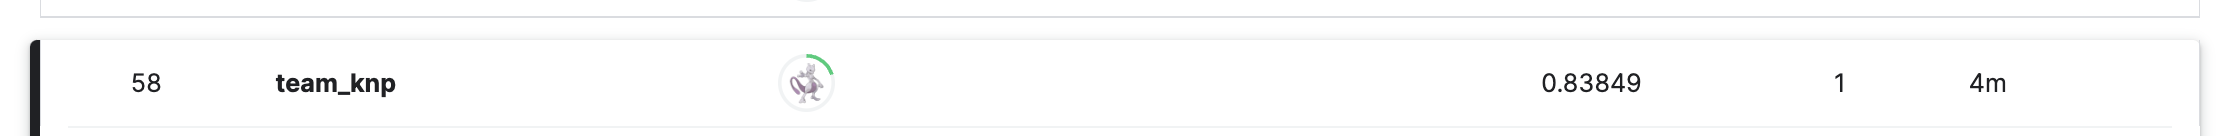

### Strategy 2 ###
RoBERTa embedding to LightGBM model: Extract meaning feature from pre-trained transformer-based RoBERTa model and use those features to train a machine learning model like LightGBM for disaster classification - "Knowledge Distillation" approach

**Explanation:**

The approach utilized in this case involves knowledge distillation, which aims to transfer the knowledge of a large, fully trained neural network to a smaller one for more practical deployment. The advantage of knowledge distillation lies in its ability to reduce computational requirements and model size while maintaining high accuracy in classification tasks. Specifically, the strategy used here involves leveraging the pre-trained RoBERTa model to obtain word embeddings, which are then fed into a machine learning LightGBM model known for its performance in classification tasks. By combining these techniques, the approach effectively classifies text data while minimizing memory usage and overfitting, ultimately leading to improved efficiency and performance in real-world applications.

In [102]:
import os
import tempfile

count = 0
chunk_size = 1000  # process data in chunks of 1000 samples
tempdir = tempfile.TemporaryDirectory()

In [103]:
# Create train-validate spilts
d_train_data, d_val_data = train_test_split(d_train_select, test_size=0.2, stratify=d_train_select['target'],
                                 random_state=2023)

s_train_data, s_val_data= train_test_split(s_train_select, test_size=0.2, stratify=s_train_select['target'],
                                 random_state=2023)

# Dropping the index because it can mess up the loops
d_train_data.reset_index(inplace=True,drop =True)
d_val_data.reset_index(inplace=True, drop =True)
s_train_data.reset_index(inplace=True, drop =True)
s_val_data.reset_index(inplace=True,  drop =True)

In [104]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }
d1_train_set= DisasterData(d_train_data, tokenizer, MAX_LEN)
d1_val_set = DisasterData(d_val_data, tokenizer, MAX_LEN)
d1_train_embed = DataLoader(d1_train_set, **train_params)
d1_val_embed = DataLoader(d1_val_set, **test_params)

In [105]:
model_embed = AutoModel.from_pretrained("roberta-base").to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [106]:
model_path = "/content/drive/MyDrive/BT5151/group_project/net_hydra_optim/hydra_optim.bin" 
model_predict = torch.load(model_path, map_location=device)

In [107]:
def get_embed(data_loader, model):
  count = 0
  chunk_size = 1000  # process data in chunks of 1000 samples
  tempdir = tempfile.TemporaryDirectory()

  with torch.no_grad():
      for i, batch in enumerate(tqdm(data_loader)):
          input_ids = batch['ids'].to(device)
          attention_mask = batch['mask'].to(device)
          label = batch['targets']
          output = model(input_ids, attention_mask=attention_mask)
          hidden_states = output.last_hidden_state.cpu().detach().numpy()[:, 0, :]
          labels = label.cpu().detach().numpy()
          np.save(os.path.join(tempdir.name, f'batch_{i}_hs.npy'), hidden_states)
          np.save(os.path.join(tempdir.name, f'batch_{i}_labels.npy'), labels)
          count += 1
          if count % chunk_size == 0:
              print('Processed', count, 'samples')
              # clear variables from memory to minimize RAM usage
              del hidden_states, labels
              torch.cuda.empty_cache()

  hidden_states = np.concatenate([np.load(os.path.join(tempdir.name, f'batch_{i}_hs.npy')) for i in range(count)], axis=0)
  labels = np.concatenate([np.load(os.path.join(tempdir.name, f'batch_{i}_labels.npy')) for i in range(count)], axis=0)

  # cleanup temporary directory
  tempdir.cleanup()
  return hidden_states, labels

In [108]:
train_hs, train_labels = get_embed(d1_train_embed, model_embed)
val_hs, val_labels = get_embed(d1_val_embed, model_embed)

100%|██████████| 48/48 [00:46<00:00,  1.03it/s]


In [198]:
def predict_hydra(model, testing_loader):
    model.eval()
    d2_predicts = []

    with torch.no_grad():
        for _, data in enumerate(tqdm(testing_loader, 0)):
            d1_ids = data['ids'].to(device, dtype = torch.long)
            d1_mask = data['mask'].to(device, dtype = torch.long)
            d1_token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            d1_targets = data['targets'].to(device, dtype = torch.long)

            _, output2 = model(d1_ids, d1_mask, d1_token_type_ids)
            
            big_val_d2, big_idx_d2 = torch.max(output2.data, dim=1)
            
            for i in range(d1_targets.size(0)):
                d2_predicts.append({
                    "predict": big_idx_d2[i].item(),
                })

    d2_df = pd.DataFrame(d2_predicts)

    return d2_df

In [150]:
train_t2_predict = predict_hydra(model_predict, d1_train_embed)
val_t2_predict = predict_hydra(model_predict, d1_val_embed)

100%|██████████| 48/48 [00:45<00:00,  1.07it/s]


In [153]:
train_t2_predict

,predict
0,0
1,1
2,0
3,1
4,1
...,...
6085,0
6086,0
6087,1
6088,1


In [167]:
train_embed = pd.DataFrame(train_hs)
train_labels_df = pd.DataFrame(train_labels, columns=['disaster'])
val_embed = pd.DataFrame(val_hs)
val_labels_df = pd.DataFrame(val_labels, columns=['disaster'])

In [168]:
# train_join = train_embed.merge(train_labels_df, left_index=True, right_index=True, suffixes=(None, "_y"))
# #train_join.drop(labels=['0_y'], axis=1, inplace=True)

# val_join = val_embed.merge(val_labels_df, left_index=True, right_index=True, suffixes=(None, "_y"))
# #val_join.drop(labels=['0_y'], axis=1, inplace=True)

In [182]:
train_final = train_embed.merge(train_t2_predict, left_index=True, right_index=True, suffixes=(None, "_y"))
#train_final.drop(labels=['0_y'], axis=1, inplace=True)

In [183]:
val_final = val_embed.merge(val_t2_predict, left_index=True, right_index=True, suffixes=(None, "_y"))


In [179]:
# train_final.to_csv("/content/drive/MyDrive/BT5151/group_project/train_strat2.csv")
# val_final.to_csv("/content/drive/MyDrive/BT5151/group_project/val_strat2.csv")

In [187]:
train_dummy = pd.get_dummies(pd.get_dummies(train_final, columns=["predict"]))
val_dummy = pd.get_dummies(pd.get_dummies(val_final, columns=["predict"]))

In [181]:
val_dummy.columns

Index([          0,           1,           2,           3,           4,
                 5,           6,           7,           8,           9,
       ...
               762,         763,         764,         765,         766,
               767,  'disaster', 'predict_0', 'predict_1', 'predict_2'],
      dtype='object', length=772)

In [188]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, Booster

In [189]:
lr_model =  LGBMClassifier()
lr_model.fit(train_dummy, train_labels)

LGBMClassifier()

In [190]:
preds_train = lr_model.predict(train_dummy)
preds_val = lr_model.predict(val_dummy)

In [191]:
accuracy_score(d_train_data['target'], preds_train)

0.9952380952380953

In [192]:
accuracy_score(d_val_data['target'], preds_val)

0.824688115561392

In [209]:
class TestData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding = 'max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
        }
    

In [210]:
d1_test_select =  d_test[['text']].copy()
d1_test_set = TestData(d1_test_select, tokenizer=tokenizer, max_len=MAX_LEN)
d1_test_embed = DataLoader(d1_test_set, **test_params)

In [211]:
def test_embed(data_loader, model):
  count = 0
  chunk_size = 1000  # process data in chunks of 1000 samples
  tempdir = tempfile.TemporaryDirectory()

  with torch.no_grad():
      for i, batch in enumerate(tqdm(data_loader)):
          input_ids = batch['ids'].to(device)
          attention_mask = batch['mask'].to(device)
          token_type_ids = batch['token_type_ids'].to(device)
          output = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
          hidden_states = output.last_hidden_state.cpu().detach().numpy()[:, 0, :]
          np.save(os.path.join(tempdir.name, f'batch_{i}_hs.npy'), hidden_states)
          count += 1
          if count % chunk_size == 0:
              print('Processed', count, 'samples')
              # clear variables from memory to minimize RAM usage
              del hidden_states
              torch.cuda.empty_cache()

  hidden_states = np.concatenate([np.load(os.path.join(tempdir.name, f'batch_{i}_hs.npy')) for i in range(count)], axis=0)

  # cleanup temporary directory
  tempdir.cleanup()
  return hidden_states

def predict_hydra_test(model, testing_loader):
  model.eval()
  d2_predicts = []

  with torch.no_grad():
      for _, data in enumerate(tqdm(testing_loader, 0)):
          d1_ids = data['ids'].to(device, dtype = torch.long)
          d1_mask = data['mask'].to(device, dtype = torch.long)
          d1_token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)

          _, output2 = model(d1_ids, d1_mask, d1_token_type_ids)
          
          big_val_d2, big_idx_d2 = torch.max(output2.data, dim=1)
          
          for i in range(d1_ids.size(0)):
              d2_predicts.append({
                  "predict": big_idx_d2[i].item(),
              })

  d2_df = pd.DataFrame(d2_predicts)

  return d2_df

In [212]:
test_hs = test_embed(d1_test_embed, model_embed)

100%|██████████| 102/102 [01:32<00:00,  1.11it/s]


In [213]:
test_t2_predict = predict_hydra_test(model_predict, d1_test_embed)

100%|██████████| 102/102 [01:35<00:00,  1.06it/s]


In [216]:
test_embed = pd.DataFrame(test_hs)
test_final = test_embed.merge(test_t2_predict, left_index=True, right_index=True, suffixes=(None, "_y"))
test_dummy = pd.get_dummies(pd.get_dummies(test_final, columns=["predict"]))

In [217]:
test_dummy.head()

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,predict_0,predict_1,predict_2
0,-0.067277,0.064045,-0.033173,-0.111211,0.065364,-0.077322,-0.034924,0.013256,0.052691,-0.073024,...,-0.066913,0.004809,0.123612,0.077959,-0.067794,-0.064513,-0.010653,0,1,0
1,-0.092448,0.081711,0.023413,-0.127079,0.083917,-0.047716,0.012487,-0.029307,0.052603,-0.108945,...,-0.079580,0.024306,0.105774,0.053831,-0.076260,-0.050434,-0.043774,0,1,0
2,-0.076121,0.057278,-0.004603,-0.133214,0.095727,-0.118897,-0.030438,0.067059,0.067372,-0.044591,...,-0.112548,0.040393,0.127375,0.074934,-0.102894,-0.090753,-0.013252,0,1,0
3,-0.057225,0.104941,0.018109,-0.131439,0.034999,-0.101398,-0.027976,-0.004108,0.067663,-0.085326,...,-0.073679,0.027149,0.120939,0.081143,-0.075973,-0.037080,-0.014002,0,1,0
4,-0.036157,0.073315,-0.010222,-0.115423,0.029333,-0.114131,-0.051055,-0.004583,0.094787,-0.057387,...,-0.090771,0.026351,0.142421,0.096038,-0.054122,-0.093459,-0.019333,0,1,0


In [218]:
preds_test = lr_model.predict(test_dummy)

In [219]:
strat2_df = pd.DataFrame(preds_test,columns =["target"])

In [220]:
strat2_df['target'].value_counts()

0    2078
1    1185
Name: target, dtype: int64

In [221]:
 # Matching the predictions indices to the Kaggle sample submission indices
strat2_df.reset_index(inplace=True)
test = d_test_orig[["id"]].copy()
strat2 = test.merge(strat2_df, left_index=True, right_index=True)
strat2.drop(labels=["index"],axis=1,inplace=True)
strat2.set_index("id",inplace=True)

strat2.to_csv("/content/drive/MyDrive/BT5151/group_project/strat2_test.csv")

In [222]:
strat2.head()

,target
id,
0,1
2,1
3,1
9,1
11,1


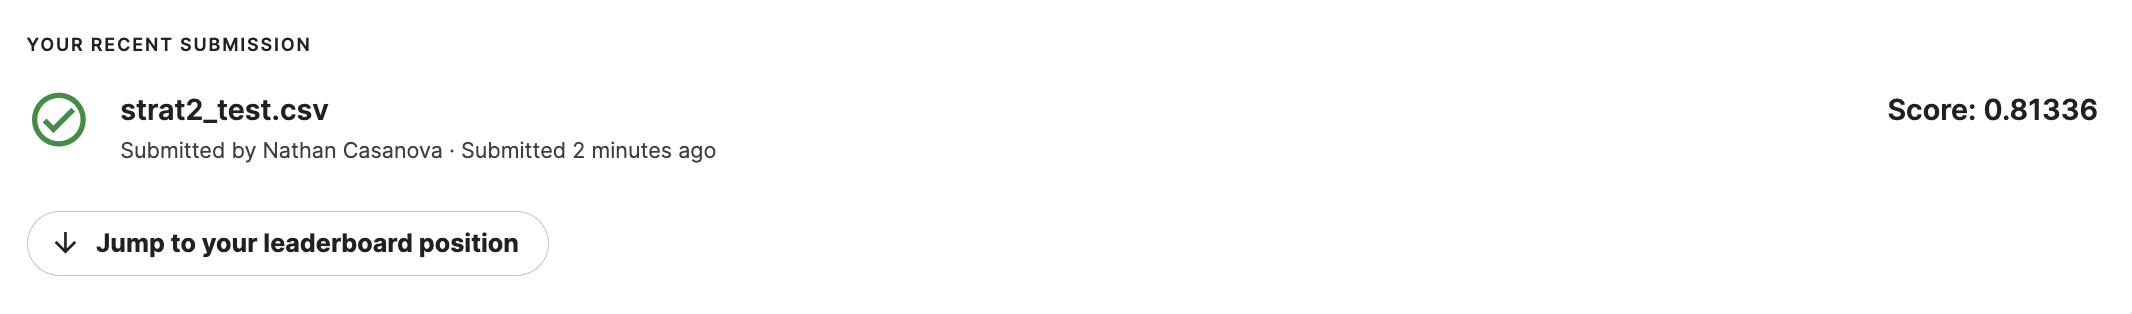